# Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Make sure this import is after pandas
import Backend.Constants as cst
import Backend.NXCALS as nx
import twissExtractor

# Importing data
database = pd.read_parquet('Data_merged/dataset_2022_05_22.parquet')
database.insert(0,'Time',(database.index - database.index[0]).total_seconds())

MDWindow = [pd.Timestamp('2022-05-22 13:30'),pd.Timestamp('2022-05-22 16:45')]
MDTime = (MDWindow[1]-MDWindow[0]).total_seconds()

#locations = ['L1B1','R1B2','L5B1','R5B2']
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]
lineInfo  = [('b','-v'),('r','-v'),('b','-^'),('r','-^')]


#============================
# finding beta function @ wire
twiss = twissExtractor.fromOptics('opticsfile.1')

for beam in beams:
    for wire in wires[beam.name]:
        _twissLoc  = [name for name in twiss[beam.name].index if ('bbcw' in name)&(wire.loc[:2].lower() in name)]
        upstream   = [name for name in _twissLoc if '.u.' in name][0]
        downstream = [name for name in _twissLoc if '.d.' in name][0]

        # Averaging beta upstream and downstream
        betx,bety = twiss[beam.name].loc[[upstream,downstream],['betx','bety']].mean()

        # Finding wire length
        #L = np.max(np.abs(twiss[beam.name].loc[[upstream,downstream],['s']].diff()))[0]
        L = 1
        
        # Attaching to wire class
        wire.betx = betx
        wire.bety = bety
        wire.L    = L






In [2]:
wire.L

1

In [3]:
for beam in beams:
    for wire in wires[beam.name]:
        print(wire.loc,wire.betx,wire.bety,wire.L)

L1B1 163.3798836266144 81.5488800490455 1
L5B1 166.41256005446527 81.32733919958042 1
R1B2 163.37992365633735 81.54888202620587 1
R5B2 166.41255061212124 81.32733792781474 1


In [4]:
np.max(database[wire['I']])

350.02576

### Tune VS Current

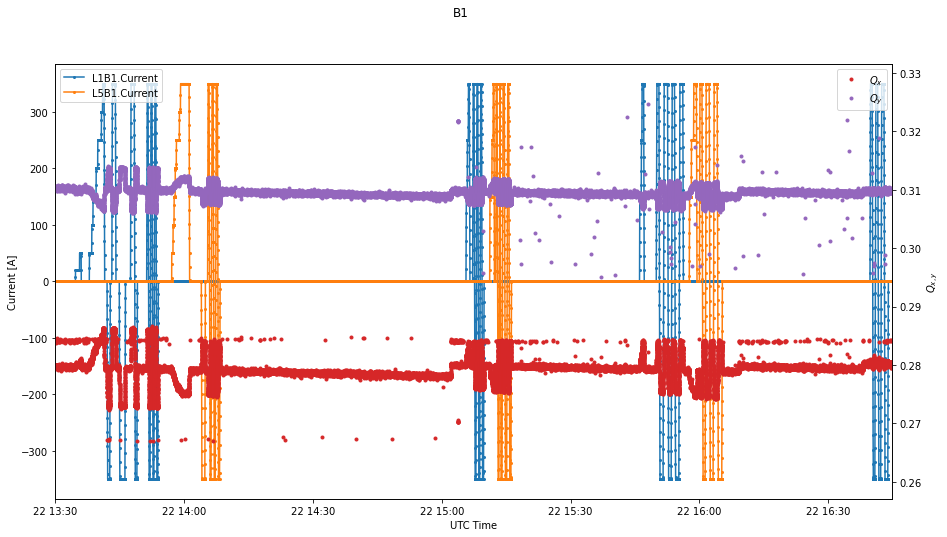

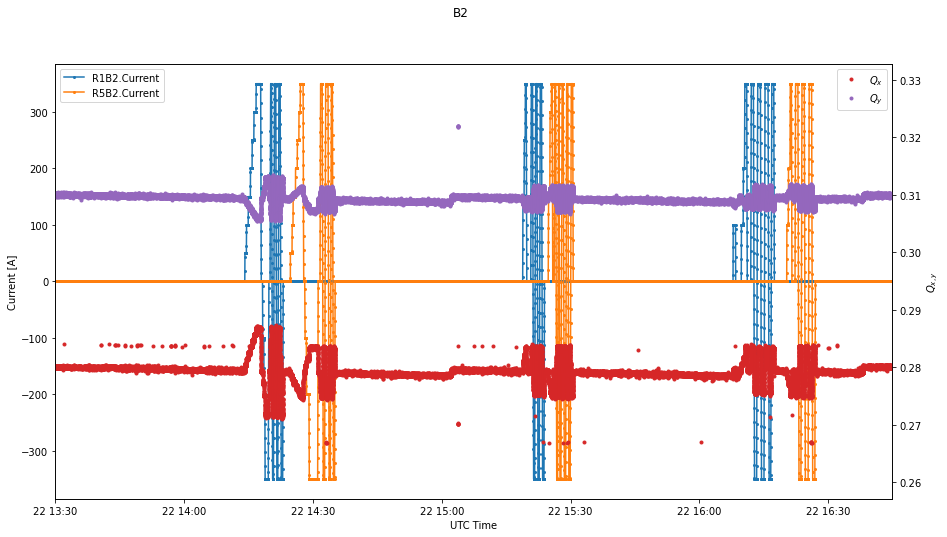

In [5]:

%matplotlib inline
#%matplotlib widget

for beam in beams:
    
    plt.figure(figsize=(15, 8))
    plt.suptitle(beam.name)
    
    
    for wire,color in zip(wires[beam.name],['C0','C1']):
        database.nxPlot('index',wire['I'],'-o',ms=2,label = wire.loc + '.' + wire.label['I'])
        
    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")
        
    ax2 = plt.gca().twinx()
    plt.sca(ax2)
    database.nxPlot('index',beam['Qx_HS'],'.',color='C3',label = beam.label['Qx_HS'])
    database.nxPlot('index',beam['Qy_HS'],'.',color='C4',label = beam.label['Qy_HS'])
    

    plt.legend(loc='upper right')
    plt.ylabel(r'$Q_{x,y}$')
    plt.xlim(MDWindow)
    
    


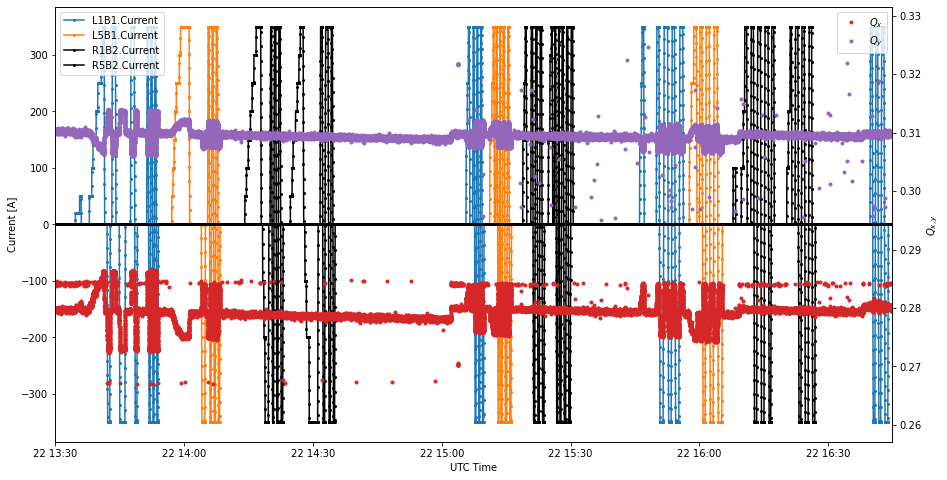

In [6]:

%matplotlib inline
#%matplotlib widget


plt.figure(figsize=(15, 8))

ax1 = plt.gca()
ax2 = plt.gca().twinx()
    
for beam in beams:
    
    
    plt.sca(ax1)
    
    for wire,color in zip(wires[beam.name],['C0','C1']):
        if beam.name == 'B2':
            color = 'k'
        database.nxPlot('index',wire['I'],'-o',color=color,ms=2,label = wire.loc + '.' + wire.label['I'])
        
    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")
        

    plt.sca(ax2)
    if beam.name == 'B2':
        pass
    else:
        database.nxPlot('index',beam['Qx_HS'],'.',color='C3',label = beam.label['Qx_HS'])
        database.nxPlot('index',beam['Qy_HS'],'.',color='C4',label = beam.label['Qy_HS'])
    

    plt.legend(loc='upper right')
    plt.ylabel(r'$Q_{x,y}$')
    plt.xlim(MDWindow)
    
    


### Reconstructing Tune shift

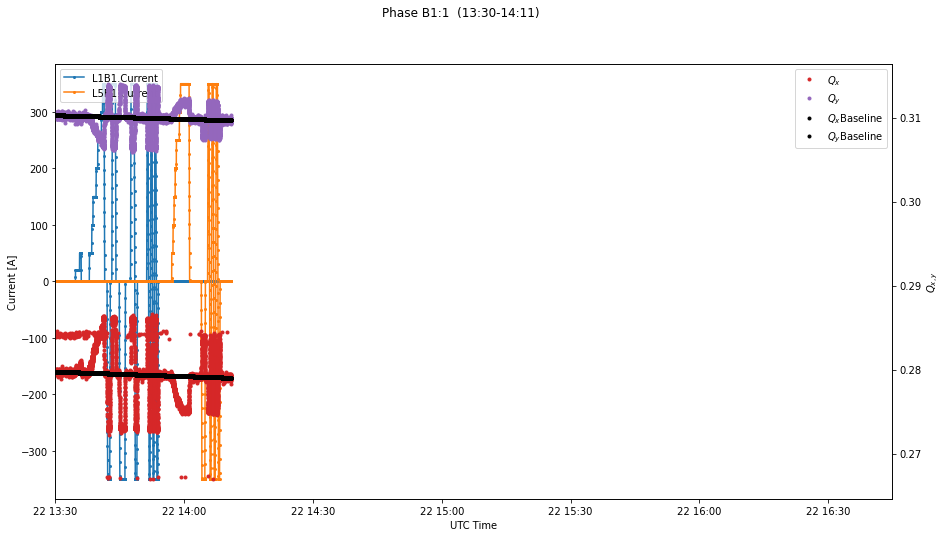

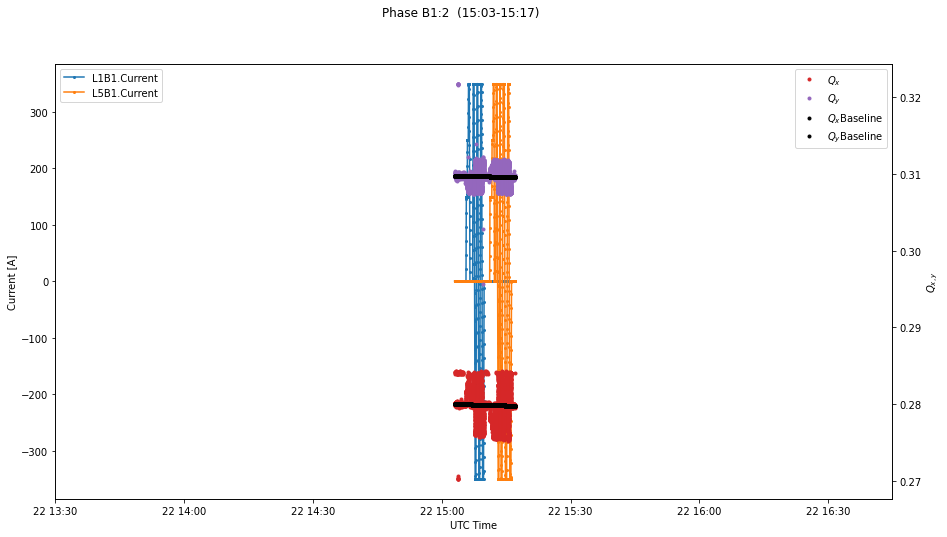

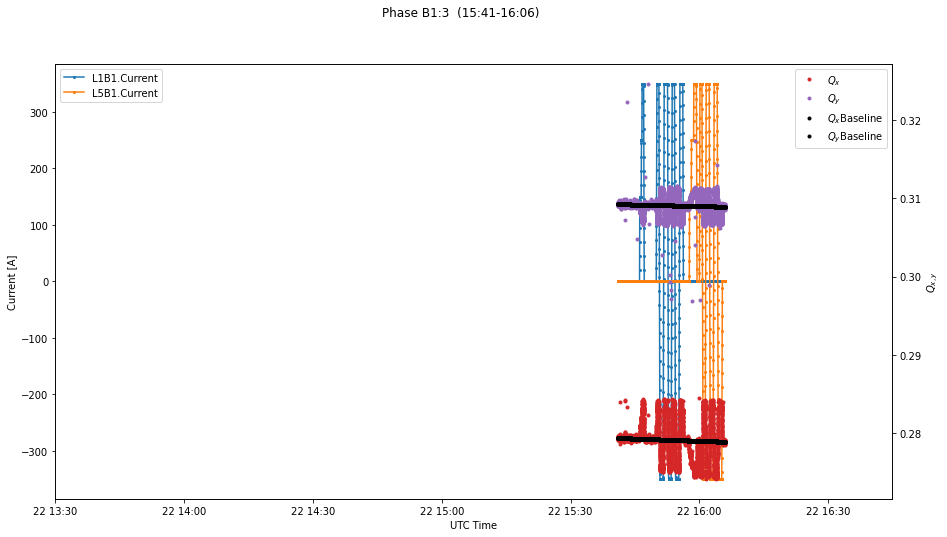

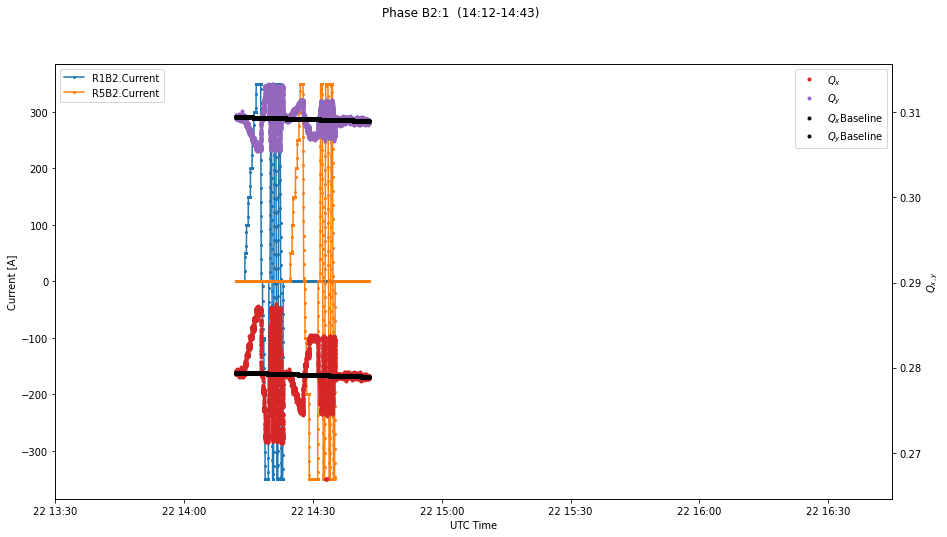

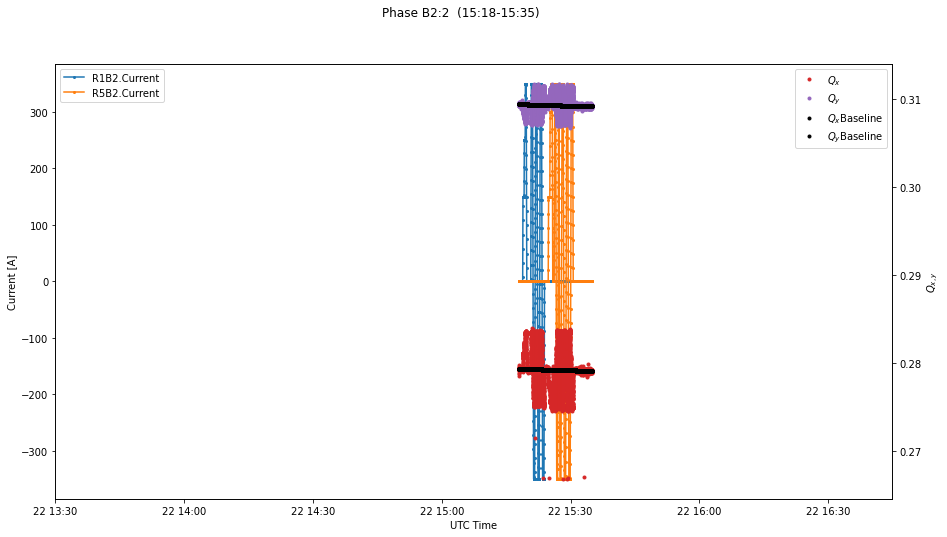

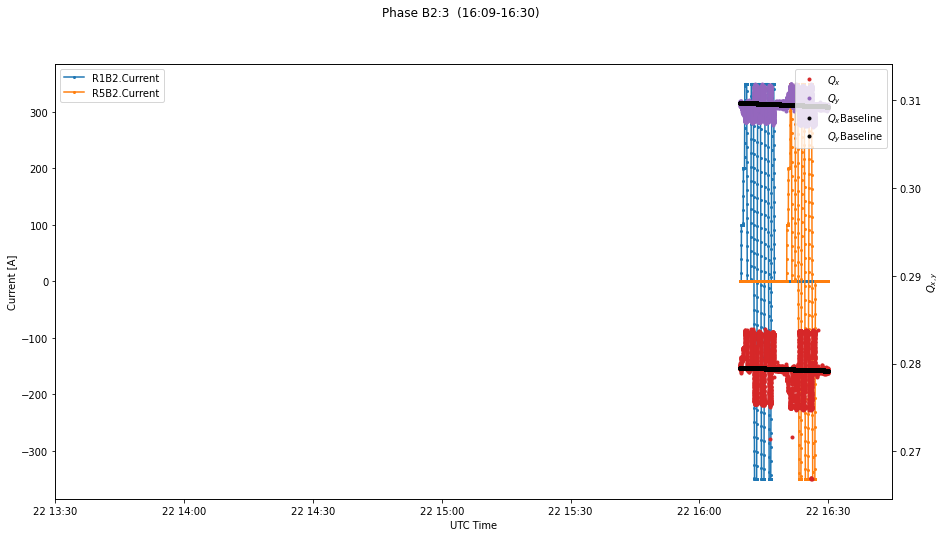

In [7]:

# Grouping data into ON-current phases for both B1 and B2
#=========================================================
phase_list= {'B1:1': [pd.Timestamp('2022-05-22 13:30')   ,pd.Timestamp('2022-05-22 14:11')],
             'B1:2': [pd.Timestamp('2022-05-22 15:03')   ,pd.Timestamp('2022-05-22 15:17')],
             'B1:3': [pd.Timestamp('2022-05-22 15:41')   ,pd.Timestamp('2022-05-22 16:06')],
             'B2:1': [pd.Timestamp('2022-05-22 14:12')   ,pd.Timestamp('2022-05-22 14:43')],
             'B2:2': [pd.Timestamp('2022-05-22 15:18')   ,pd.Timestamp('2022-05-22 15:35')],
             'B2:3': [pd.Timestamp('2022-05-22 16:09:30'),pd.Timestamp('2022-05-22 16:30')]
            }

if 'Phase' not in database.columns:
    database.insert(1,'Phase','None')
    for name,_window in phase_list.items():
        cutting = pd.cut(database.index,bins=_window)

        database.loc[list(database.groupby(cutting).get_group(cutting.categories[0]).index),'Phase']  = name
#==========================================================



grouped = database.groupby('Phase')

for name, group in grouped:
    if name == 'None':
        continue
            
    # Selecting proper beam and wires for the group
    beam = [beam for beam in beams if beam.name in name][0]
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]

    # Extracting tune info
    subset = group.dropna(subset=[beam['Qx_HS']])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']

    # Finding location of ON/OFF current
    ON_wire1 = np.interp(tuneTimes, group.dropna(subset=[wire1['I']])['Time'],
                                    group.dropna(subset=[wire1['I']])[wire1['I']])

    ON_wire2 = np.interp(tuneTimes, group.dropna(subset=[wire2['I']])['Time'],
                                    group.dropna(subset=[wire2['I']])[wire2['I']])

    # Setting values to 0 or 1
    ON_wire1[np.abs(ON_wire1)<0.1] = 0
    ON_wire2[np.abs(ON_wire2)<0.1] = 0
    #-----
    ON_wire1[np.abs(ON_wire1)>0.1] = 1
    ON_wire2[np.abs(ON_wire2)>0.1] = 1


    # Keeping only values when both are off
    ON_baseline = np.invert(ON_wire1.astype(bool))*np.invert(ON_wire2.astype(bool))



    def baseline(t,a,b):
        return a*t+b


    t  = tuneTimes[ON_baseline]
    for tune in [beam['Qy_HS'],beam['Qx_HS']]:
        if tune+'_baseline' not in database.columns:
            database.insert(2,tune+'_baseline',np.nan)
            database.insert(3,tune+'_shift',np.nan)

        Q = subset[tune][ON_baseline]

        cutoff = 4*np.std(Q)
        outliers = np.abs(Q-np.mean(Q))>cutoff

        popt, pcov = curve_fit(baseline, t[~outliers],Q[~outliers])

        database.loc[tuneIndex,tune+'_baseline'] = baseline(tuneTimes,*popt)
        database.loc[tuneIndex,tune+'_shift']    = subset[tune] - baseline(tuneTimes,*popt)

        
        
grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
            
    # Selecting proper beam 
    beam = [beam for beam in beams if beam.name in name][0] 
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    # Plot current in wire
    for wire,color in zip(wires[beam.name],['C0','C1']):
        
        group.nxPlot('index',wire['I'],'-o',color=color,ms=2,label = wire.loc + '.' + wire.label['I'])

    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")


    ax2 = plt.gca().twinx()
    plt.sca(ax2)

    group.nxPlot('index',beam['Qx_HS'],'.',color='C3',label = beam.label['Qx_HS'])
    group.nxPlot('index',beam['Qy_HS'],'.',color='C4',label = beam.label['Qy_HS'])

    group.nxPlot('index',beam['Qx_HS']+'_baseline','.',color='k',label = beam.label['Qx_HS']+'Baseline')
    group.nxPlot('index',beam['Qy_HS']+'_baseline','.',color='k',label = beam.label['Qy_HS']+'Baseline')


    plt.legend(loc='upper right')
    plt.ylabel(r'$Q_{x,y}$')
    plt.xlim(MDWindow)


# Plotting tune shift

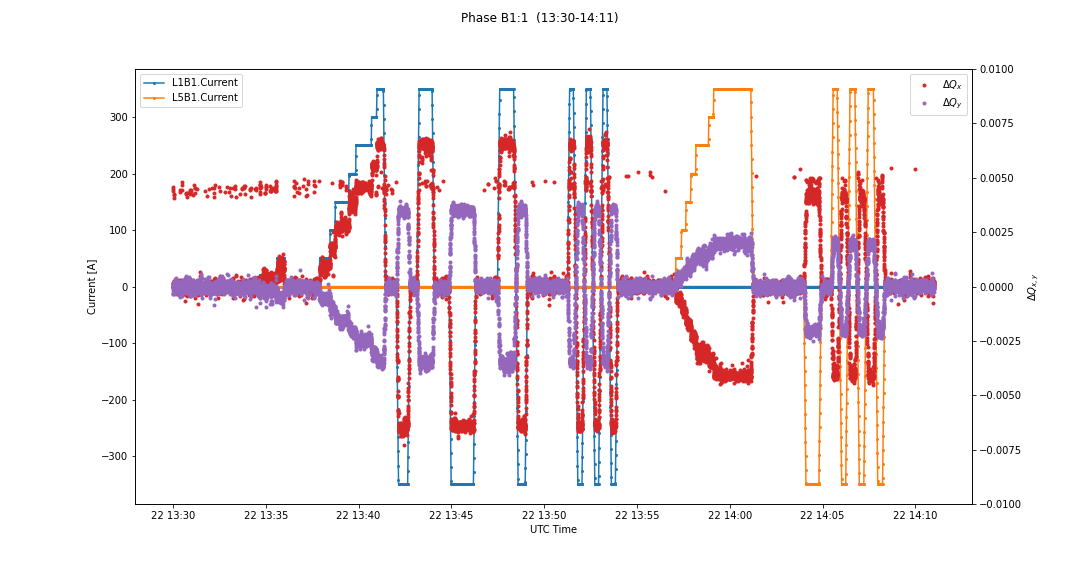

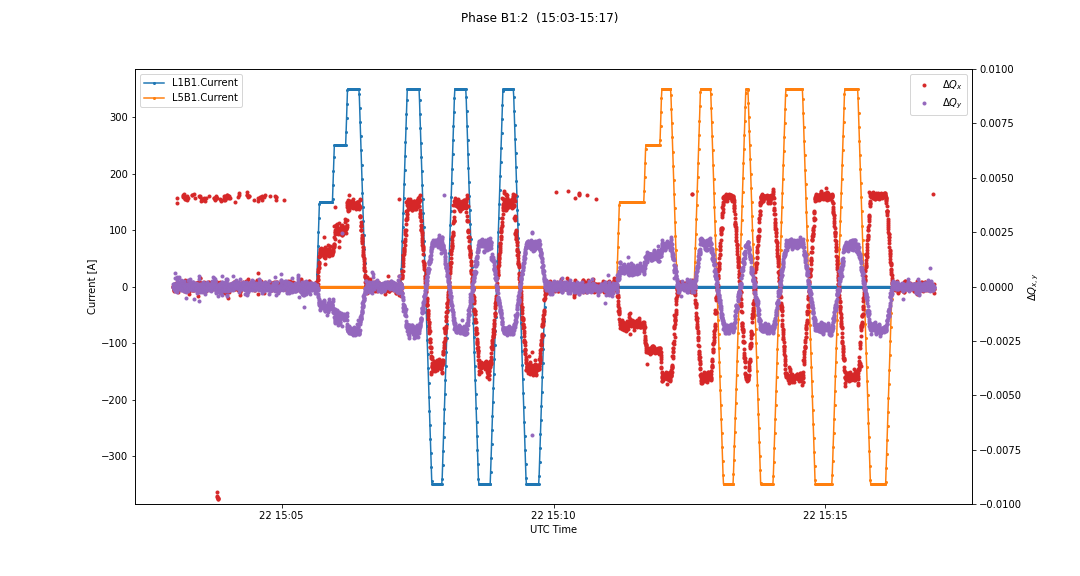

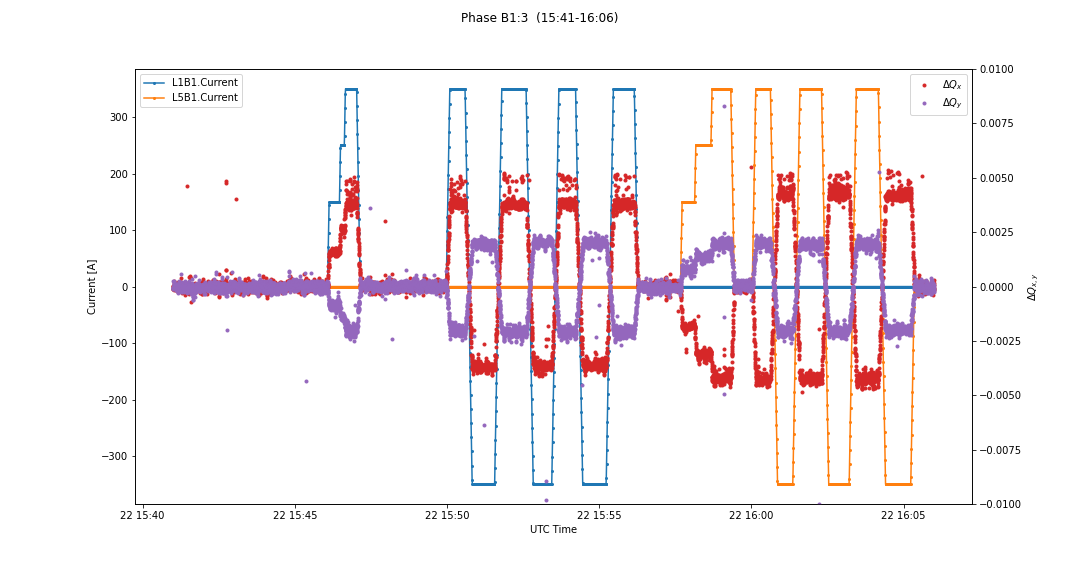

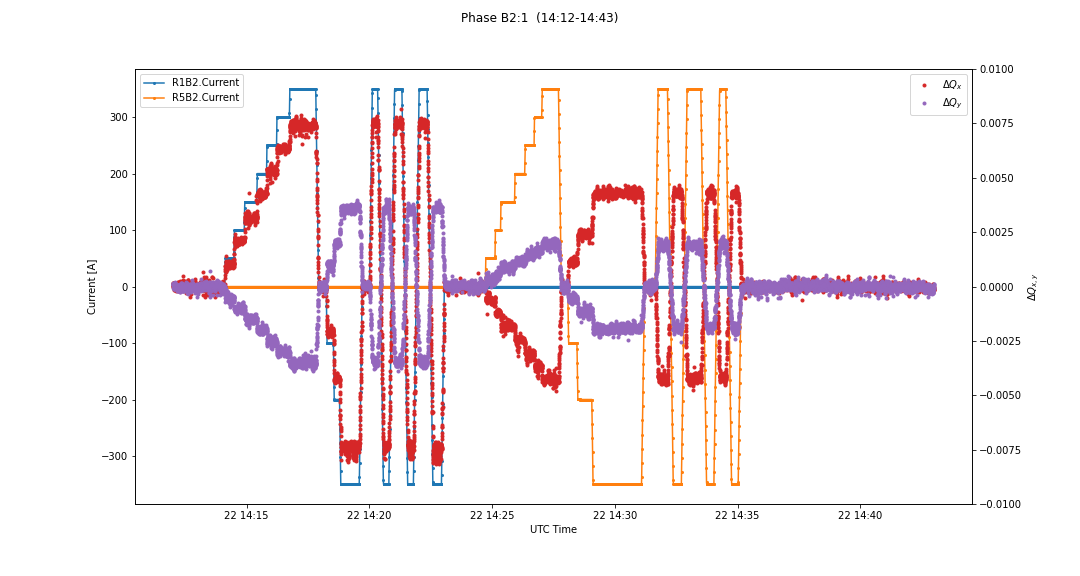

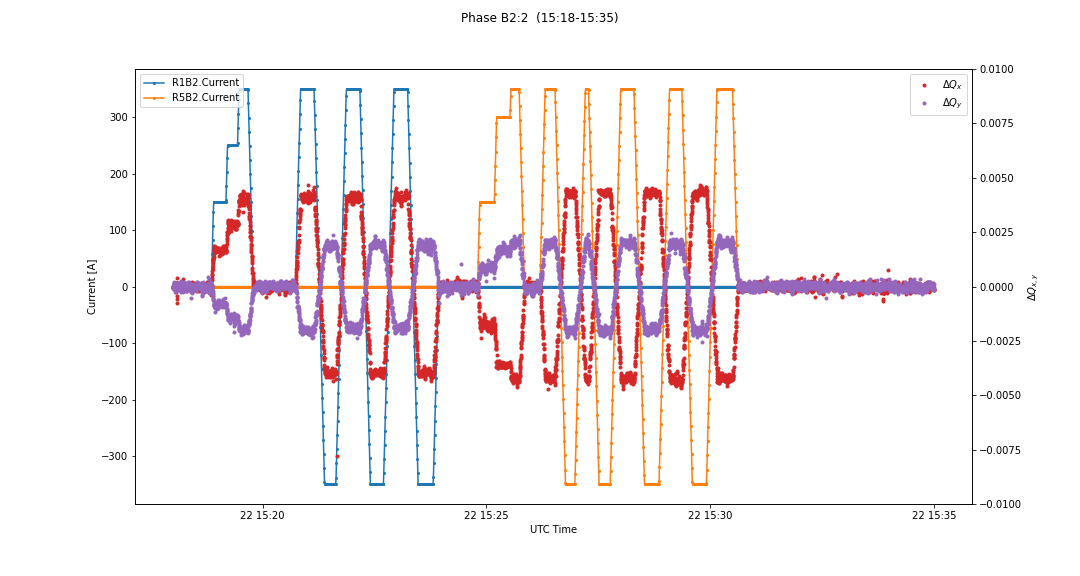

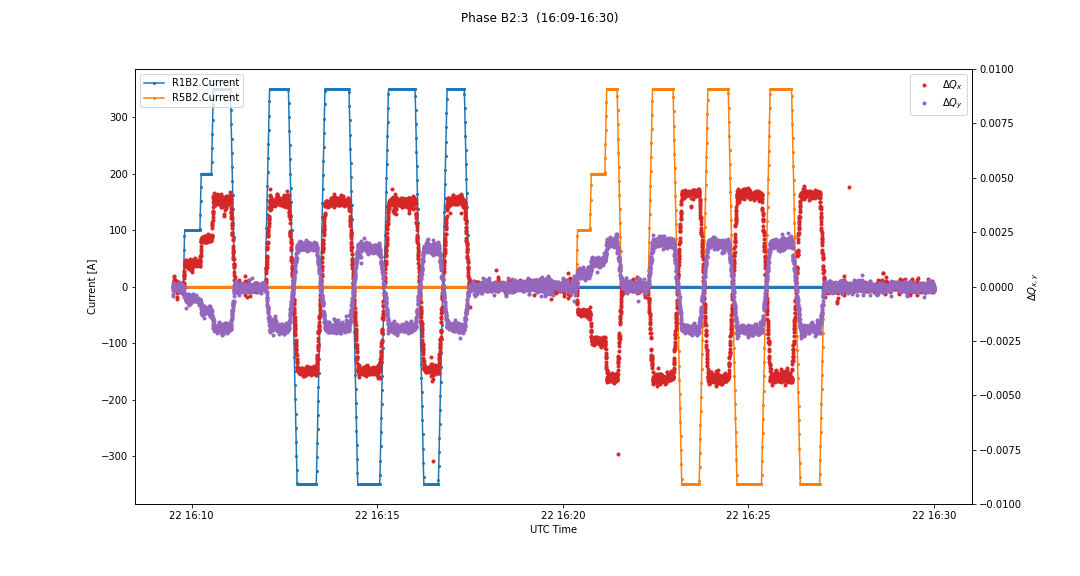

In [8]:
%matplotlib widget

grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
            
    # Selecting proper beam 
    beam = [beam for beam in beams if beam.name in name][0]  
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    # Plot current in wire
    for wire,color in zip(wires[beam.name],['C0','C1']):
        group.nxPlot('index',wire['I'],'-o',color=color,ms=2,label = wire.loc + '.' + wire.label['I'])

    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")


    ax2 = plt.gca().twinx()
    plt.sca(ax2)


    group.nxPlot('index',beam['Qx_HS']+'_shift','.',color='C3',label = r'$\Delta$'+beam.label['Qx_HS'])
    group.nxPlot('index',beam['Qy_HS']+'_shift','.',color='C4',label = r'$\Delta$'+beam.label['Qy_HS'])
    plt.ylim([-0.01,0.01])

    plt.legend(loc='upper right')
    plt.ylabel(r'$\Delta Q_{x,y}$')
    #plt.xlim(MDWindow)
    
    

# Tune Shift vs current

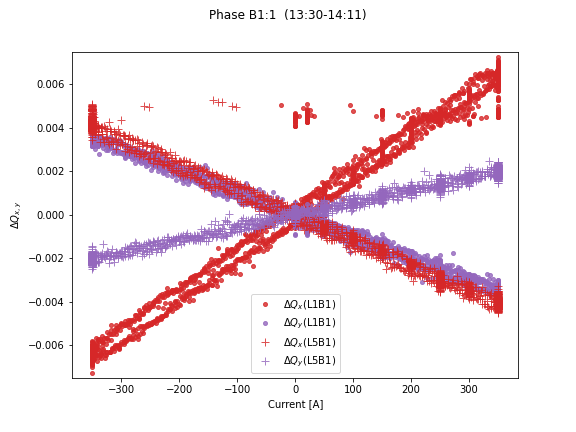

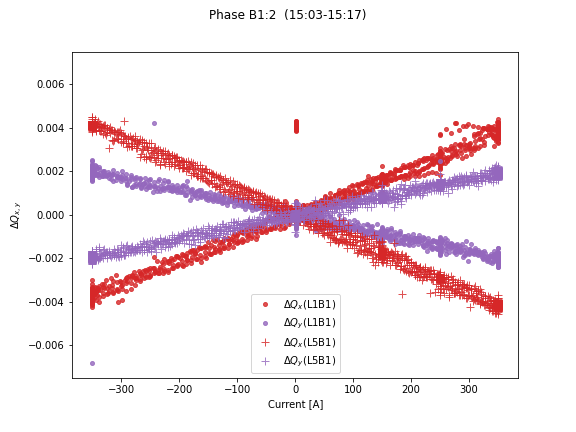

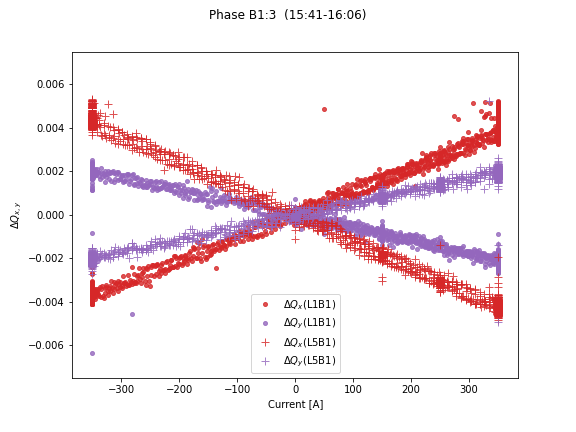

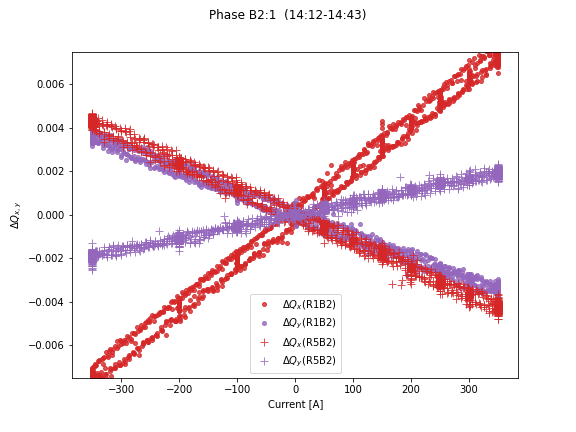

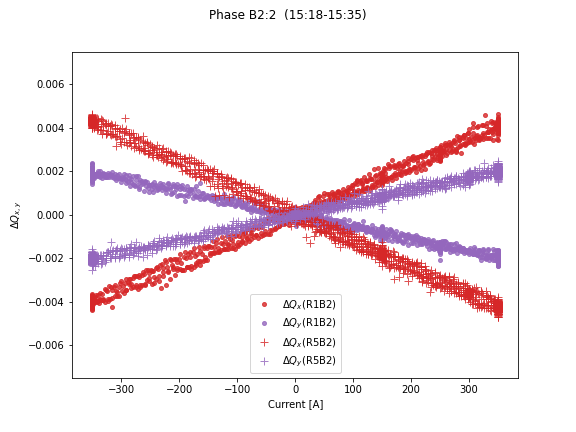

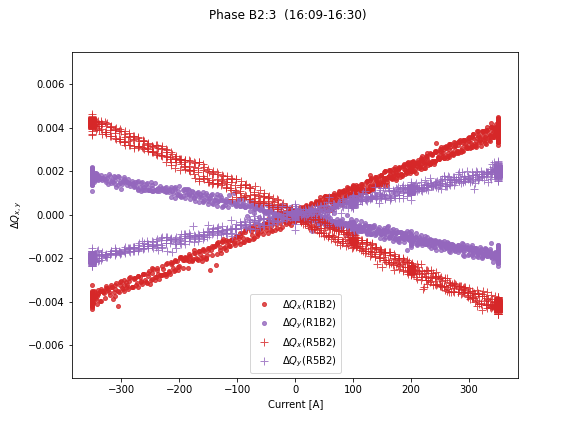

In [9]:


    
    
%matplotlib widget

grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
            
    # Selecting proper beam and wires for the group
    beam = [beam for beam in beams if beam.name in name][0]
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]
    
    
    # Extracting tune info
    subset = group.dropna(subset=[beam['Qx_HS']+'_shift'])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']
    
    DQx = subset[beam['Qx_HS']+'_shift']
    DQy = subset[beam['Qy_HS']+'_shift']
    

    # Interpolating both currents
    I_wire1 = np.interp(tuneTimes, group.dropna(subset=[wire1['I']])['Time'],
                                   group.dropna(subset=[wire1['I']])[wire1['I']])

    I_wire2 = np.interp(tuneTimes, group.dropna(subset=[wire2['I']])['Time'],
                                   group.dropna(subset=[wire2['I']])[wire2['I']])
    
    # Choosing which current to look at
    on_wire1 = (np.abs(I_wire1)>0.1) & (np.abs(I_wire1)>np.abs(I_wire2))
    on_wire2 = (np.abs(I_wire2)>0.1) & (np.abs(I_wire2)>np.abs(I_wire1))
    
    plt.figure(figsize=(8, 6))
    plt.suptitle('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    
    plt.plot(I_wire1[on_wire1],DQx[on_wire1],'.',ms=8,alpha=0.8,color='C3',label=r'$\Delta Q_x$' + f'({wire1.loc})')
    plt.plot(I_wire1[on_wire1],DQy[on_wire1],'.',ms=8,alpha=0.8,color='C4',label=r'$\Delta Q_y$' + f'({wire1.loc})')
    
    plt.plot(I_wire2[on_wire2],DQx[on_wire2],'+',ms=8,alpha=0.8,color='C3',label=r'$\Delta Q_x$' + f'({wire2.loc})')
    plt.plot(I_wire2[on_wire2],DQy[on_wire2],'+',ms=8,alpha=0.8,color='C4',label=r'$\Delta Q_y$' + f'({wire2.loc})')
    
    plt.legend()
    
    plt.ylim([-0.0075,0.0075])
    
    plt.ylabel(r'$\Delta Q_{x,y}$')
    plt.xlabel(f"{wire.label['I']} [{wire.units['I']}]")
    
    

# Looking at collimator Gap

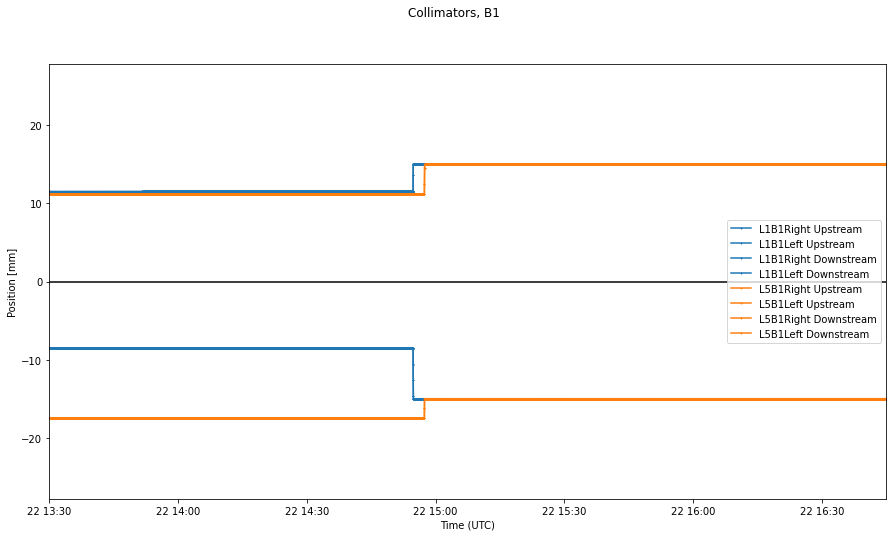

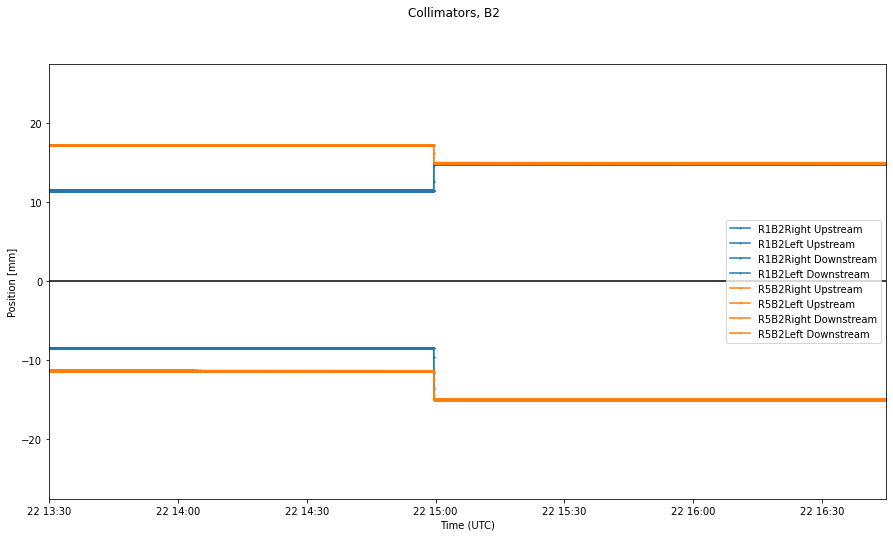

In [10]:

%matplotlib inline
#%matplotlib widget

for beam in beams:
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Collimators, ' + beam.name)
    for wire,color in zip(wires[beam.name],['C0','C1']):
        for pos,var in wire.Position.items():
            database.nxPlot('index',var,'-+',color=color,ms=2,label = wire.loc+pos)
    plt.axhline(0,color='k')
    plt.legend()
    plt.ylabel(f"{wire.label['Position']} [{wire.units['Position']}]")
    plt.xlabel(r'Time (UTC)')
    plt.xlim(MDWindow)


# 5th axis alignment

Let's focus on phases 2-3 for now since the collimator settings are symmetric.

In the double wire configuration, the wires might be misaligned with regard to the beam. That is, in IP1 (vertical crossing), the two wires will be centered in the vertical plane, but might be misaligned on the horizontal plane. Starting from the multipolar expansion:


$$\begin{aligned} K_{N_n} + iK_{S_n} = -\frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \frac{n!}{\left(r_w e^{i\phi_w}\right)^{n+1}}  \end{aligned}$$

and assuming that the two wires are at an angle $\pm\phi_w$ with regard to the beam, one finds:

$$\begin{aligned} K_{N_n} + iK_{S_n} &= -\frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\frac{e^{-i(n+1)\phi_w} + e^{i(n+1)\phi_w}}{r_w^{n+1}} \right]n!\\
\sum_n \frac{K_{N_n} + iK_{S_n}}{n!} &= -\frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\overbrace{\frac{2\cos(\phi_w)}{r_w}}^{\text{Dipole}}
+ \overbrace{\frac{2\cos(2\phi_w)}{r_w^2}}^{\text{Quad.}}
+ \overbrace{\frac{2\cos(3\phi_w)}{r_w^3}}^{\text{Sext.}}
+ \overbrace{\frac{2\cos(4\phi_w)}{r_w^4}}^{\text{Octu.}}
+\dots\right]\end{aligned}$$

In the case where $\pm \phi_w = \pm \pi/2$, the odd multipoles are cancelled out, but this is not the case otherwise. The tune shift from the quadrupolar and octupolar contribution is :

$$\begin{aligned}\Delta Q_x (J_x, J_y) &= \delta Q_{1,x} + \delta Q_{3,x}(J_x,J_y)\\
&= -\frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\frac{1}{4\pi} \frac{2\cos(2\phi_w)}{r_w^2} \beta_x + \frac{3}{8\pi}\frac{2\cos(4\phi_w)}{r_w^4}\Big[\beta_x^2J_x - 2\beta_x\beta_yJ_y\Big]\right]\\
&= -\frac{1}{B\rho}\frac{\mu_0 (I L)}{8\pi^2} \left[ \frac{2\cos(2\phi_w)}{r_w^2} \beta_x + \frac{2\cos(4\phi_w)}{r_w^4} \frac{3}{2}\Big[\beta_x^2J_x - 2\beta_x\beta_yJ_y\Big]\right]\end{aligned}$$

In [11]:
#=========================================
# Fitting function
#=========================================
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

def dQxdQy(I, xw , yw , betx, bety, Jx = 0 , Jy = 0 ,E = 450e9,L=1):
    rw,phiw = cart2pol(xw, yw)
    
    Brho = np.sqrt(E**2-cst.m_p_eV**2)/cst.c
    Q0   = -cst.mu0*(I*L)/(Brho*8*np.pi**2)
    
    quad = 2*np.cos(2*phiw)/rw**2
    octu = 2*np.cos(4*phiw)/rw**4 * (3/2)
    
    dQx  = Q0*( 1*quad*betx + octu*(betx**2*Jx - 2*betx*bety*Jy))
    dQy  = Q0*(-1*quad*bety + octu*(bety**2*Jy - 2*bety*betx*Jx))
    
    return dQx,dQy
#==========================================
print(dQxdQy(350, 0     , 12e-3 , 160, 80, E = 450e9,L=1))
print(dQxdQy(350, 12e-3 , 0     , 160, 80, E = 450e9,L=1))

(0.008246787337209788, -0.004123393668604894)
(-0.008246787337209788, 0.004123393668604894)


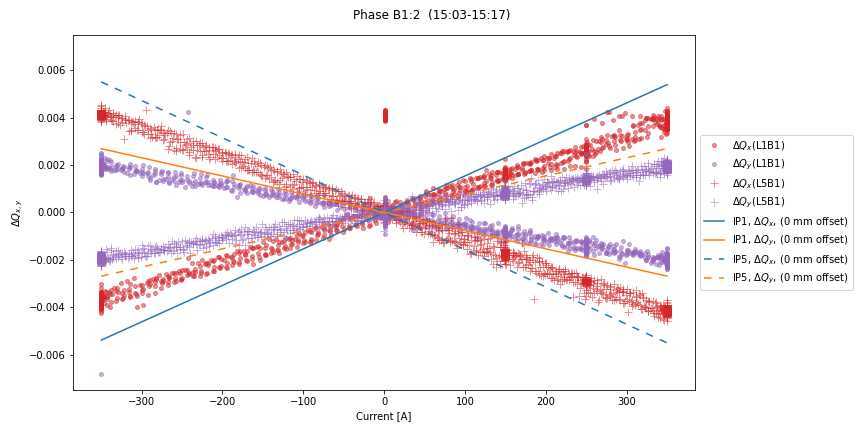

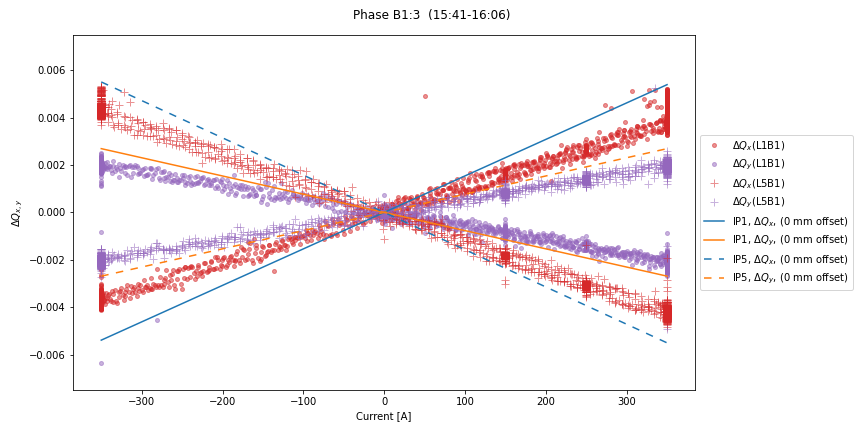

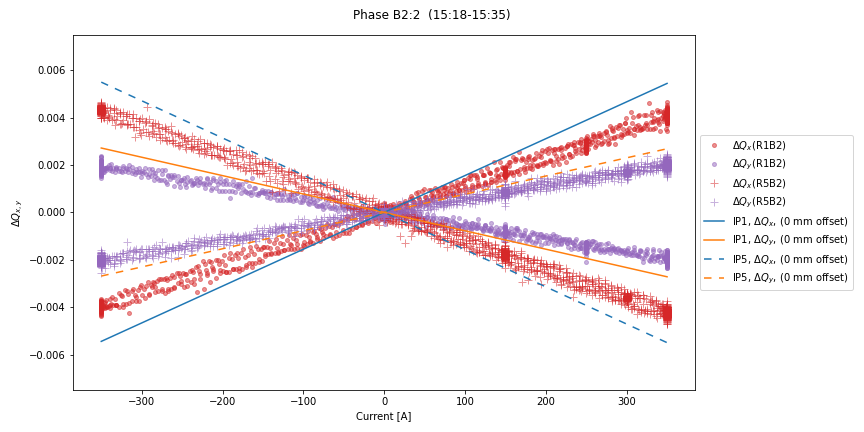

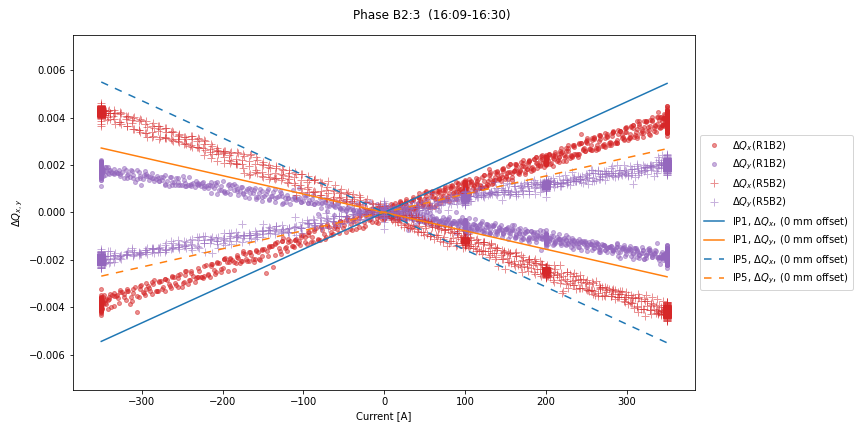

In [12]:
   
%matplotlib widget

grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
    
    # SKIPPING PHASE 1
    if ':1' in name:
        continue
            
    # Selecting proper beam and wires for the group
    beam = [beam for beam in beams if beam.name in name][0]
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]
    
    
    # Extracting tune info
    subset = group.dropna(subset=[beam['Qx_HS']+'_shift'])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']
    
    DQx = subset[beam['Qx_HS']+'_shift']
    DQy = subset[beam['Qy_HS']+'_shift']
    

    # Interpolating both currents
    I_wire1 = np.interp(tuneTimes, group.dropna(subset=[wire1['I']])['Time'],
                                   group.dropna(subset=[wire1['I']])[wire1['I']])

    I_wire2 = np.interp(tuneTimes, group.dropna(subset=[wire2['I']])['Time'],
                                   group.dropna(subset=[wire2['I']])[wire2['I']])
    
    # Choosing which current to look at
    on_wire1 = (np.abs(I_wire1)>0.1) & (np.abs(I_wire1)>np.abs(I_wire2))
    on_wire2 = (np.abs(I_wire2)>0.1) & (np.abs(I_wire2)>np.abs(I_wire1))
    
    plt.figure(figsize=(12, 6))
    plt.suptitle('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    
    plt.plot(I_wire1[on_wire1],DQx[on_wire1],'.',ms=8,alpha=0.5,color='C3',label=r'$\Delta Q_x$' + f'({wire1.loc})')
    plt.plot(I_wire1[on_wire1],DQy[on_wire1],'.',ms=8,alpha=0.5,color='C4',label=r'$\Delta Q_y$' + f'({wire1.loc})')
    
    plt.plot(I_wire2[on_wire2],DQx[on_wire2],'+',ms=8,alpha=0.5,color='C3',label=r'$\Delta Q_x$' + f'({wire2.loc})')
    plt.plot(I_wire2[on_wire2],DQy[on_wire2],'+',ms=8,alpha=0.5,color='C4',label=r'$\Delta Q_y$' + f'({wire2.loc})')
    
    # Analytic expression
    I_vec = np.linspace(-350,350,100)
    for wire in [wire1,wire2]:
        IP = 'IP' + wire.loc[1]
        
        left_coll  = group[[wire.Position['Left Upstream'] ,wire.Position['Left Downstream']]].dropna().mean(axis=1)
        right_coll = group[[wire.Position['Right Upstream'],wire.Position['Right Downstream']]].dropna().mean(axis=1)
        # Convert mm to m
        d_coll     = 1e-3*np.mean(left_coll-right_coll)/2
        
        if IP == 'IP1':
            dQx,dQy = dQxdQy(I_vec,xw = 0     ,yw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            ls='-'
        else:
            dQx,dQy = dQxdQy(I_vec,xw = d_coll,yw = 0, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            ls=(0,(5,5))
        plt.plot(I_vec,dQx,linestyle =ls,color='C0',label=IP + r', $\Delta Q_x$, (0 mm offset)')
        plt.plot(I_vec,dQy,linestyle =ls,color='C1',label=IP + r', $\Delta Q_y$, (0 mm offset)')
        
        
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylim([-0.0075,0.0075])
    
    plt.ylabel(r'$\Delta Q_{x,y}$')
    plt.xlabel(f"{wire.label['I']} [{wire.units['I']}]")
    plt.tight_layout()
    
    

## With an offset?

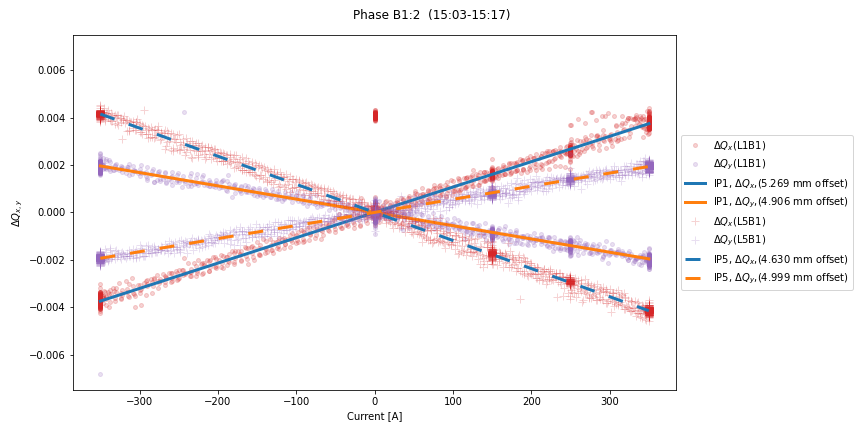

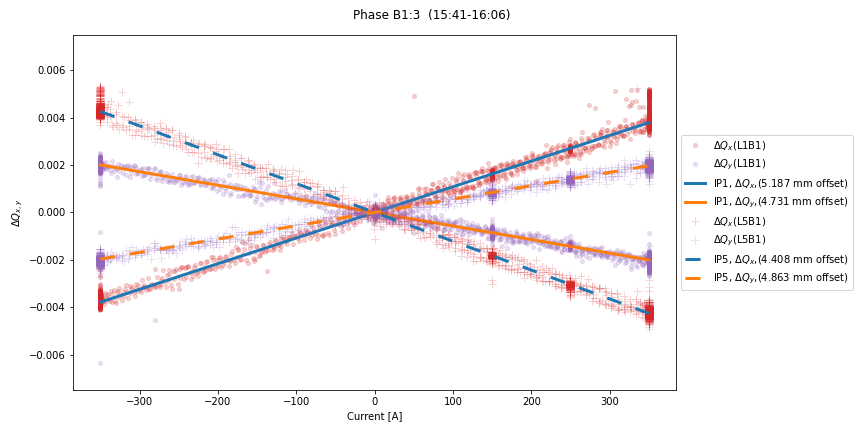

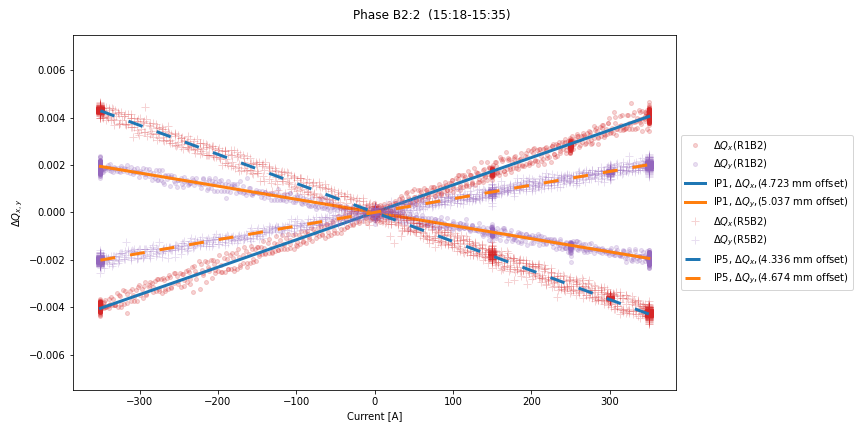

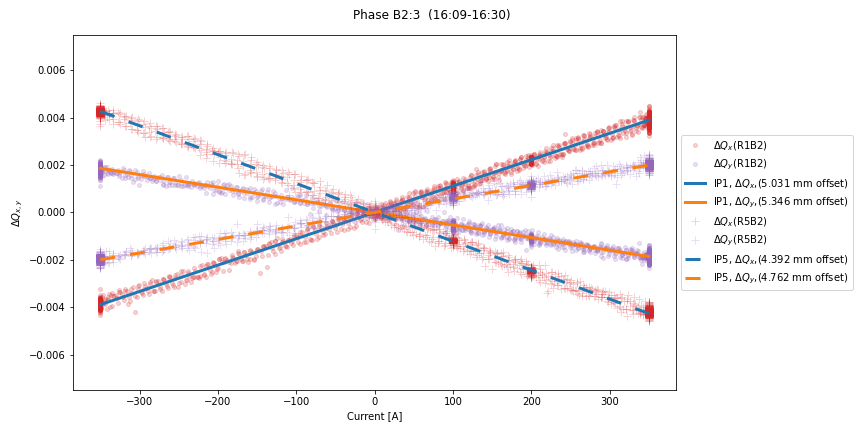

In [13]:
   
%matplotlib widget

grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
    
    # SKIPPING PHASE 1
    if ':1' in name:
        continue
            
    # Selecting proper beam and wires for the group
    beam = [beam for beam in beams if beam.name in name][0]
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]
    
    
    # Extracting tune info
    subset = group.dropna(subset=[beam['Qx_HS']+'_shift'])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']
    
    DQx = subset[beam['Qx_HS']+'_shift']
    DQy = subset[beam['Qy_HS']+'_shift']
    

    # Interpolating both currents
    I_wire1 = np.interp(tuneTimes, group.dropna(subset=[wire1['I']])['Time'],
                                   group.dropna(subset=[wire1['I']])[wire1['I']])

    I_wire2 = np.interp(tuneTimes, group.dropna(subset=[wire2['I']])['Time'],
                                   group.dropna(subset=[wire2['I']])[wire2['I']])
    
    # Choosing which current to look at
    on_wire1 = (np.abs(I_wire1)>0.1) & (np.abs(I_wire1)>np.abs(I_wire2))
    on_wire2 = (np.abs(I_wire2)>0.1) & (np.abs(I_wire2)>np.abs(I_wire1))
    
    plt.figure(figsize=(12, 6))
    plt.suptitle('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    
    I_vec = np.linspace(-350,350,100)
    for wire,I_wire,on_wire in zip([wire1,wire2],[I_wire1,I_wire2],[on_wire1,on_wire2]):
        IP = 'IP' + wire.loc[1]
        if IP == 'IP1':
            mark = '.'
        else:
            mark = '+'
         
        # For each wire, plotting DQx, DQy
        I_data, DQx_data, DQy_data = I_wire[on_wire],DQx[on_wire],DQy[on_wire]
        plt.plot(I_data, DQx_data,mark,ms=8,alpha=0.2,color='C3',label=r'$\Delta Q_x$' + f'({wire.loc})')
        plt.plot(I_data, DQy_data,mark,ms=8,alpha=0.2,color='C4',label=r'$\Delta Q_y$' + f'({wire.loc})')
        
        
        # Finding collimator position
        left_coll  = group[[wire.Position['Left Upstream'] ,wire.Position['Left Downstream']]].dropna().mean(axis=1)
        right_coll = group[[wire.Position['Right Upstream'],wire.Position['Right Downstream']]].dropna().mean(axis=1)
        # Convert mm to m
        d_coll     = 1e-3*np.mean(left_coll-right_coll)/2
        
        # Fitting!
        if IP == 'IP1':
            def dQxfit(I,offset):
                dQx,_ = dQxdQy(I,xw = offset, yw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
                return dQx
            
            def dQyfit(I,offset):
                _,dQy = dQxdQy(I,xw = offset, yw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
                return dQy
                
            popt_Qx, pcov = curve_fit(dQxfit,I_data,DQx_data,p0 = [1e-3],bounds=(- 20e-3, 20e-3))
            popt_Qy, pcov = curve_fit(dQyfit,I_data,DQy_data,p0 = [1e-3],bounds=(- 20e-3, 20e-3))
            
            ls='-'
        else:
            def dQxfit(I,offset):
                dQx,_ = dQxdQy(I,yw = offset, xw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
                return dQx
            
            def dQyfit(I,offset):
                _,dQy = dQxdQy(I,yw = offset, xw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
                return dQy
                
            popt_Qx, pcov = curve_fit(dQxfit,I_data,DQx_data,p0 = [1e-3],bounds=(- 20e-3, 20e-3))
            popt_Qy, pcov = curve_fit(dQyfit,I_data,DQy_data,p0 = [1e-3],bounds=(- 20e-3, 20e-3))
            
            ls=(0,(5,5))
            
        plt.plot(I_vec,dQxfit(I_vec,*popt_Qx),linestyle =ls,lw=3,color='C0',label=IP + r', $\Delta Q_x$,'+ f'({popt_Qx[0]/1e-3:.3f} mm offset)')
        plt.plot(I_vec,dQyfit(I_vec,*popt_Qy),linestyle =ls,lw=3,color='C1',label=IP + r', $\Delta Q_y$,'+ f'({popt_Qy[0]/1e-3:.3f} mm offset)')
        
        # Saving offset results
        if f'Offset_{IP}_dQx' not in database.columns:
            database.insert(2,f'Offset_{IP}_dQx',np.nan)
            database.insert(3,f'Offset_{IP}_dQy',np.nan)
        
        database.loc[tuneIndex,f'Offset_{IP}_dQx'] = popt_Qx[0]
        database.loc[tuneIndex,f'Offset_{IP}_dQy'] = popt_Qy[0]
        
        
        
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylim([-0.0075,0.0075])
    
    plt.ylabel(r'$\Delta Q_{x,y}$')
    plt.xlabel(f"{wire.label['I']} [{wire.units['I']}]")
    plt.tight_layout()
    
    

In [14]:
grouped = database.groupby('Phase')

# Looking for diffenrence between phase 2 and 3


for beam in ['B1','B2']:  
    print('\n\n')
    name = f'{beam}:2'
    print('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    name = f'{beam}:3'
    print('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    print(40*'=')

    for IP in ['IP1','IP5']:
        change_x = grouped.get_group(f'{beam}:2')[f'Offset_{IP}_dQx'].dropna()[-1] - grouped.get_group(f'{beam}:3')[f'Offset_{IP}_dQx'].dropna()[-1]
        change_y = grouped.get_group(f'{beam}:2')[f'Offset_{IP}_dQy'].dropna()[-1] - grouped.get_group(f'{beam}:3')[f'Offset_{IP}_dQy'].dropna()[-1]
        
        print(f'({beam},{IP}),Phase2-Phase3 offset change\n \t from Qx :{change_x/1e-3:.2f} mm\n \t from Qy :{change_y/1e-3:.2f} mm\n' + 40*'-')
    print(40*'=')




Phase B1:2  (15:03-15:17)
Phase B1:3  (15:41-16:06)
(B1,IP1),Phase2-Phase3 offset change
 	 from Qx :0.08 mm
 	 from Qy :0.17 mm
----------------------------------------
(B1,IP5),Phase2-Phase3 offset change
 	 from Qx :0.22 mm
 	 from Qy :0.14 mm
----------------------------------------



Phase B2:2  (15:18-15:35)
Phase B2:3  (16:09-16:30)
(B2,IP1),Phase2-Phase3 offset change
 	 from Qx :-0.31 mm
 	 from Qy :-0.31 mm
----------------------------------------
(B2,IP5),Phase2-Phase3 offset change
 	 from Qx :-0.06 mm
 	 from Qy :-0.09 mm
----------------------------------------
